In [53]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EDA 참고 : https://skyjwoo.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-EDAExploratory-Data-Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import re # 정규표현식 사용 모듈

from sklearn.feature_extraction.text import TfidfVectorizer
# 자연어처리 함수인데.. 모델링 때 더 자세히 알아보기 ㅎㅎ; / https://mingchin.tistory.com/7 참고 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import Sequential
# tensorflow와 keras 모두 딥러닝을 쉽게 구현하도록 한 라이브러리/프레임워크
# 쟤네들이 뭐하는 함수인지는 뒤에 사용할 때 정리하장

In [3]:
train      = pd.read_csv("/content/drive/MyDrive/github_commit/sooktat_DL_project/dataset/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/github_commit/sooktat_DL_project/dataset/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/github_commit/sooktat_DL_project/dataset/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/github_commit/sooktat_DL_project/dataset/topic_dict.csv")

In [10]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


### 제목 길이 히스토그램
25-30자 내의 뉴스제목이 대부분

Text(0.5, 0, 'length')

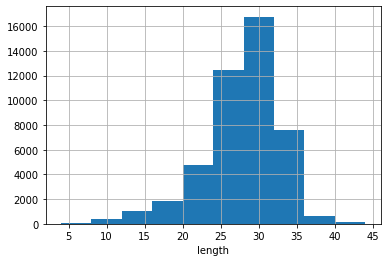

In [13]:
ax = train.title.str.len().hist()
ax.set_xlabel("length")

### 토큰 개수 히스토그램 (공백기준)
6-8 개의 토큰이 가장 많음

Text(0.5, 0, '# of tokens')

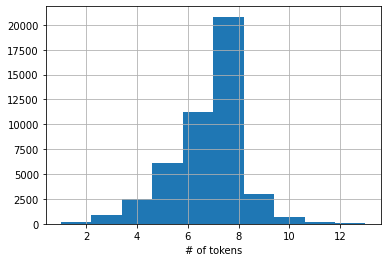

In [19]:
ax = train.title.str.split(' ').map(lambda x: len(x)).hist()
ax.set_xlabel("# of tokens")

### 형태소 분석

#### 형태소 분석기 Mecab 설치


In [22]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2023-01-17 14:28:14--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-01-17 14:28:14--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceba9011399e4fbd832258e916e.dl.dropboxusercontent.com/cd/0/get/B0s9ZthY_ya0VhbrYFBNTZ4rNYfCU-ebDd6XSIViov6FOCxgJkyN4jJ6Tp_Kscw0GY0y5HoLK8SR9Whzzb4-Nx4VgmSXamZDk_m8Am5f1ZBKliAOS-nq3ZyOqe4dMVUVB6fWPUPd3kjNY_qN1YojSBVZ7dYSj5-_Qvq_jq0Fjx7qpv7SZl2YbdOBW69W9ktVb34/file?dl=1# [following]
--2023-01-17 14:28:14--  https://uceba9011399e4fbd832258e916e.dl.dropboxusercontent.com/cd/0/get/B0s9ZthY_ya

In [4]:
from konlpy.tag import Okt, Mecab
mecab = Mecab()


mecab.morphs() : 형태소 분할  
mecab.pos() : 형태소 분할 + 품사까지 알려줌

In [25]:
mecab.morphs('한글 형태소 분석기(미켑)로 테스트를 해보았습니다. 정상 설치 및 동작이 잘 됩니다.') # 정상 작동 확인 

['한글',
 '형태소',
 '분석기',
 '(',
 '미',
 '켑',
 ')',
 '로',
 '테스트',
 '를',
 '해',
 '보',
 '았',
 '습니다',
 '.',
 '정상',
 '설치',
 '및',
 '동작',
 '이',
 '잘',
 '됩니다',
 '.']

In [26]:
mecab.pos('한글 형태소 분석기(미켑)로 테스트를 해보았습니다. 정상 설치 및 동작이 잘 됩니다.') # 정상 작동 확인 

[('한글', 'NNG'),
 ('형태소', 'NNG'),
 ('분석기', 'NNG'),
 ('(', 'SSO'),
 ('미', 'NNG'),
 ('켑', 'UNKNOWN'),
 (')', 'SSC'),
 ('로', 'JKB'),
 ('테스트', 'NNG'),
 ('를', 'JKO'),
 ('해', 'VV+EC'),
 ('보', 'VX'),
 ('았', 'EP'),
 ('습니다', 'EF'),
 ('.', 'SF'),
 ('정상', 'NNG'),
 ('설치', 'NNG'),
 ('및', 'MAJ'),
 ('동작', 'NNG'),
 ('이', 'JKS'),
 ('잘', 'MAG'),
 ('됩니다', 'VV+EF'),
 ('.', 'SF')]

In [5]:
joins = train.title.to_list()

In [6]:
units = []
for i in joins:
    units.extend(mecab.morphs(i))

In [39]:
units

['인천',
 '→',
 '핀란드',
 '항공기',
 '결항',
 '…',
 '휴가철',
 '여행객',
 '분통',
 '실리콘밸리',
 '넘어서',
 '겠',
 '다',
 '…',
 '구글',
 '15',
 '조',
 '원',
 '들여',
 '美',
 '전역',
 '거점',
 '화',
 '이란',
 '외무',
 '긴장',
 '완화',
 '해결책',
 '은',
 '미국',
 '이',
 '경제',
 '전쟁',
 '멈추',
 '는',
 '것',
 'NYT',
 '클린턴',
 '측근',
 '韓',
 '기업',
 '특수',
 '관계',
 '조명',
 '…',
 '공과',
 '사',
 '맞물려',
 '종합',
 '시진핑',
 '트럼프',
 '에',
 '중미',
 '무역',
 '협상',
 '조속',
 '타결',
 '희망',
 '팔레스타인',
 '가',
 '자',
 '지',
 '구서',
 '16',
 '세',
 '소년',
 '이스라엘',
 '군',
 '총격',
 '에',
 '사망',
 '인도',
 '48',
 '년',
 '만',
 '에',
 '파키스탄',
 '공습',
 '…',
 '테러',
 '캠프',
 '폭격',
 '종합',
 '2',
 '보',
 '美',
 '대선',
 'TV',
 '토론',
 '음담패설',
 '만회',
 '실패',
 '트럼프',
 '…',
 '사과',
 '대신',
 '빌클린턴',
 '공격',
 '해',
 '역효과',
 '푸틴',
 '한반도',
 '상황',
 '진전',
 '위한',
 '방안',
 '김정은',
 '위원장',
 '과',
 '논의',
 '특검',
 '면죄부',
 '받',
 '은',
 '트럼프',
 '스캔들',
 '보도',
 '언론',
 '맹공',
 '…',
 '국민',
 '의',
 '적',
 '日',
 '오키',
 '나와서',
 '열린',
 '강제',
 '징용',
 '노동자',
 '추도식',
 '이란',
 '서',
 '최고',
 '지도자',
 '모욕',
 '혐의',
 '미국인',
 '에',
 '징역',
 '10',
 '년',
 '선고',
 '카

In [7]:
import collections
unit_count = collections.Counter(units)
most = unit_count.most_common() # 빈도 수로 나열

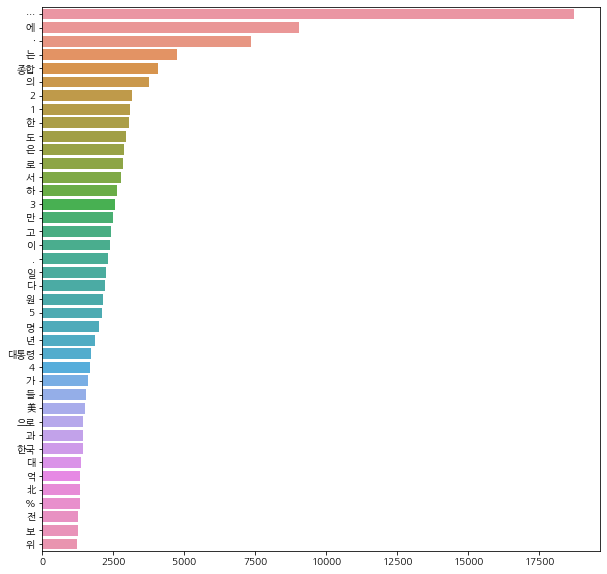

In [9]:
word, count = [], []
for i, j in most[:40]:
    word.append(i)
    count.append(j)

plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=count, y=word)

음... 의미가 없는 조사나 특수기호가 대부분을 차지함. -> 한글자 수 제외하고 다시 해보기

In [25]:
up2_units = []
for i in units:
    if len(i) > 1:
        up2_units.append(i)

In [26]:
up2_units

['인천',
 '핀란드',
 '항공기',
 '결항',
 '휴가철',
 '여행객',
 '분통',
 '실리콘밸리',
 '넘어서',
 '구글',
 '15',
 '들여',
 '전역',
 '거점',
 '이란',
 '외무',
 '긴장',
 '완화',
 '해결책',
 '미국',
 '경제',
 '전쟁',
 '멈추',
 'NYT',
 '클린턴',
 '측근',
 '기업',
 '특수',
 '관계',
 '조명',
 '공과',
 '맞물려',
 '종합',
 '시진핑',
 '트럼프',
 '중미',
 '무역',
 '협상',
 '조속',
 '타결',
 '희망',
 '팔레스타인',
 '구서',
 '16',
 '소년',
 '이스라엘',
 '총격',
 '사망',
 '인도',
 '48',
 '파키스탄',
 '공습',
 '테러',
 '캠프',
 '폭격',
 '종합',
 '대선',
 'TV',
 '토론',
 '음담패설',
 '만회',
 '실패',
 '트럼프',
 '사과',
 '대신',
 '빌클린턴',
 '공격',
 '역효과',
 '푸틴',
 '한반도',
 '상황',
 '진전',
 '위한',
 '방안',
 '김정은',
 '위원장',
 '논의',
 '특검',
 '면죄부',
 '트럼프',
 '스캔들',
 '보도',
 '언론',
 '맹공',
 '국민',
 '오키',
 '나와서',
 '열린',
 '강제',
 '징용',
 '노동자',
 '추도식',
 '이란',
 '최고',
 '지도자',
 '모욕',
 '혐의',
 '미국인',
 '징역',
 '10',
 '선고',
 '카니발',
 '축제',
 '브라질',
 '리우',
 '대형',
 '유람선',
 '행렬',
 '올랜도',
 '병원',
 '최악',
 '총기',
 '테러',
 '부상자',
 '치료비',
 '는다',
 '기업',
 '올해',
 '평균',
 '46',
 '임금',
 '인상',
 'WMO',
 '엘니뇨',
 '여전히',
 '강력',
 '분기',
 '소멸',
 '이스라엘',
 '네타냐후',
 '유대교',
 '병역',
 '문제',
 '연정',
 '협상',
 '진

In [30]:
import collections
unit_count2 = collections.Counter(up2_units)
most2 = unit_count2.most_common() # 빈도 수로 나열

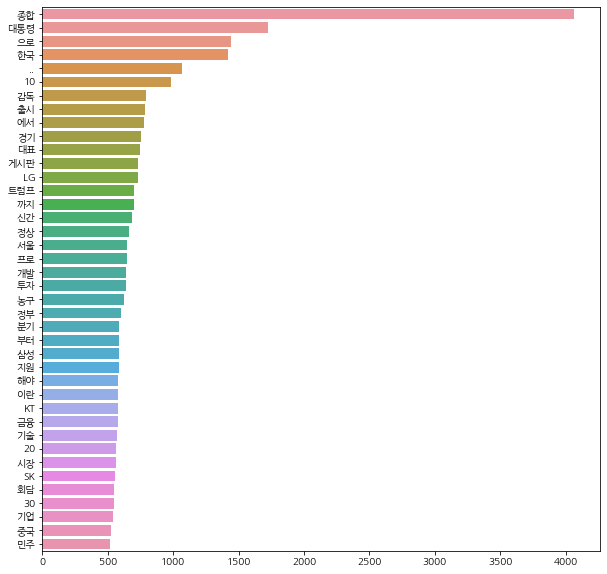

In [31]:
word, count = [], []
for i, j in most2[:40]:
    word.append(i)
    count.append(j)

plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=count, y=word)

종합, 대통령, 한국, 감독, 출시 등이 인기 단어 (?)

* 참고사항 : 사용자 사전 활용   
사용자 사전이란 ? 
한국어의 형태소 분석은 자연어 처리 분야에서 악명높기로 유명하다. 띄어쓰기가 잘 지켜지지 않아도 사람은 해석이 되는 언어인지라 기계가 인식할 때 굉장히 난항을 겪게 된다. 때문에 아무리 우수한 형태소 분석기라도 100%의 정확도를 보여주기는 어려워서, 중요한 단어에 대해서 직접 단어를 사용자 사전에 추가할 수 있다.
이는 형태소 분석이 잘못된 단어들이거나 신조어, 외래어와 같은 단어들의 예외처리를 할 때 유용하다.  
[출처] [Mecab] 사용자 사전 추가하기|작성자 IML

#### train 데이터의 각 토픽 별 형태소 분석

In [35]:
topic_1 = train[train.topic_idx == 1]
topic_2 = train[train.topic_idx == 2]
topic_3 = train[train.topic_idx == 3]
topic_4 = train[train.topic_idx == 4]

In [36]:
# 형태소 분석 함수
def analysis(data):
    joins = data.title.to_list()
    units = []
    for i in joins:
        units.extend(mecab.morphs(i))
    up2_units = []
    for i in units:
        if len(i) > 1:
            up2_units.append(i)
    import collections
    unit_count2 = collections.Counter(up2_units)
    most2 = unit_count2.most_common() # 빈도 수로 나열
    word, count = [], []
    for i, j in most2[:40]:
        word.append(i)
        count.append(j)

    plt.rcParams['font.family'] = 'NanumGothic'
    plt.figure(figsize=(10,10))
    sns.barplot(x=count, y=word)


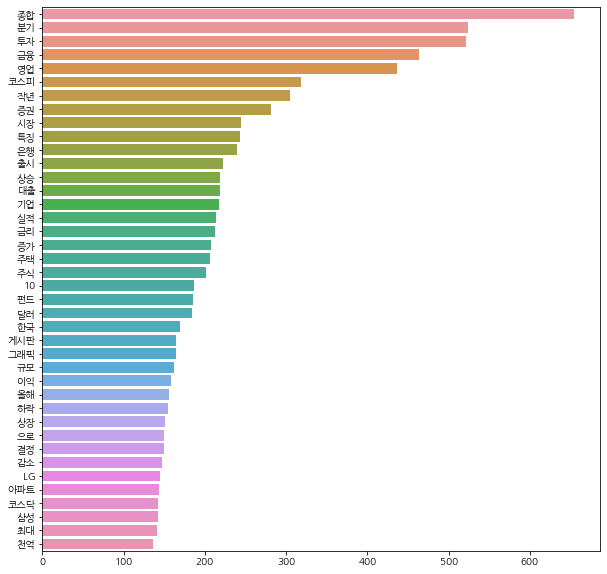

In [37]:
# topic 1 기사들의 형태소 분석 : 분기, 투자, 금융, 영업, 코스피, 은행, 증권 등 '경제' 관련된 토픽이라고 추정됨
analysis(topic_1)

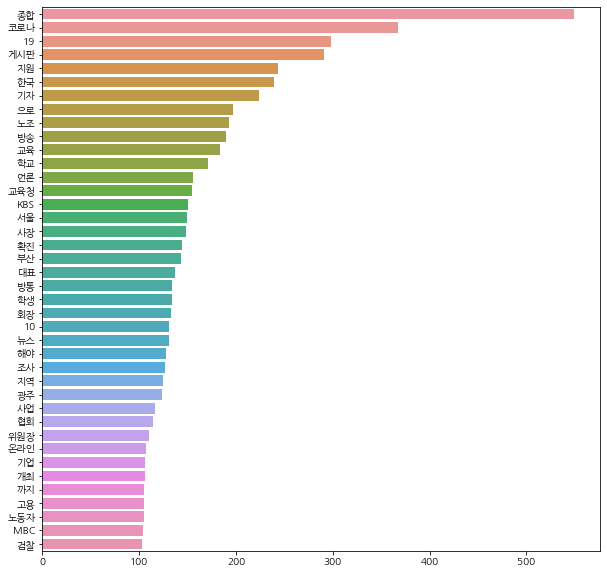

In [38]:
# topic 2 기사들의 형태소 분석 : 코로나19, 지원, 한국, 기자, 노조, 방송, 교육, 언론, 서울 등 한국의 '정치/사회'에 대한 토픽으로 추정됨
analysis(topic_2)

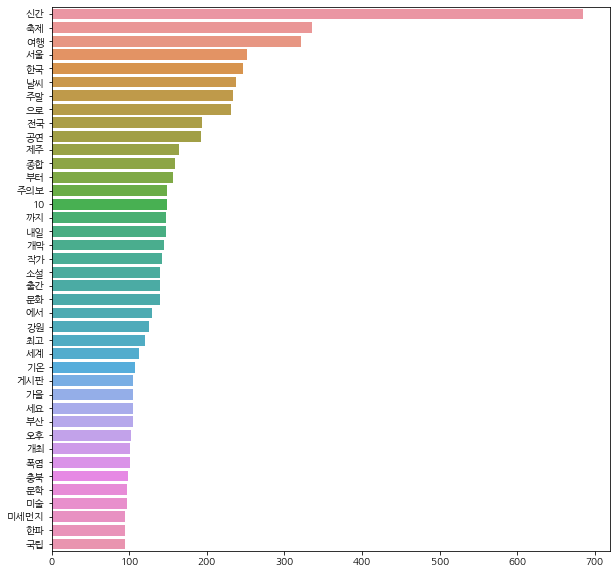

In [39]:
# topic 3 기사들의 형태소 분석 : 축제, 여행, 서울, 날씨, 주말, 공연, 제주, 주의보, 작가, 소설 등 '문화/여가' 관련한 토픽으로 추정됨
analysis(topic_3)

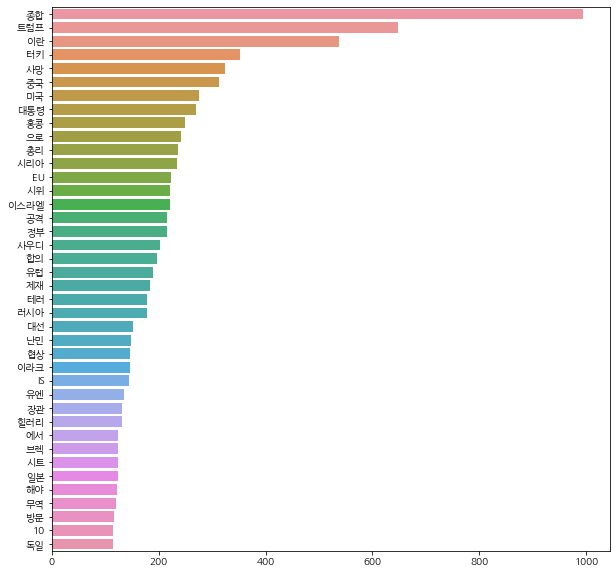

In [40]:
# topic 4 기사들의 형태소 분석 : 트럼프, 이란, 터키, 중국, 미국, 대통령, 홍콩, EU 등 '해외/국제' 토픽으로 추정됨
analysis(topic_4)

<형태소 분석 결과>  

topic 1 : 경제  
topic 2 : 정치/사회  
topic 3 : 문화/여가  
topic 4 : 해외/국제  

In [41]:
def clean_text(sent):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  return sent_clean

train["cleaned_title"] = train["title"].apply(lambda x : clean_text(x))
test["cleaned_title"]  = test["title"].apply(lambda x : clean_text(x))

train_text = train["cleaned_title"].tolist()
test_text = test["cleaned_title"].tolist()
train_label = np.asarray(train.topic_idx)

tfidf = TfidfVectorizer(analyzer='word', sublinear_tf=True, ngram_range=(1, 2), max_features=150000, binary=False)

tfidf.fit(train_text)

train_tf_text = tfidf.transform(train_text).astype('float32')
test_tf_text  = tfidf.transform(test_text).astype('float32')

자연어처리 eda 참고 : https://skyjwoo.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-EDAExploratory-Data-Analysis